# 变化B，mu的color相图

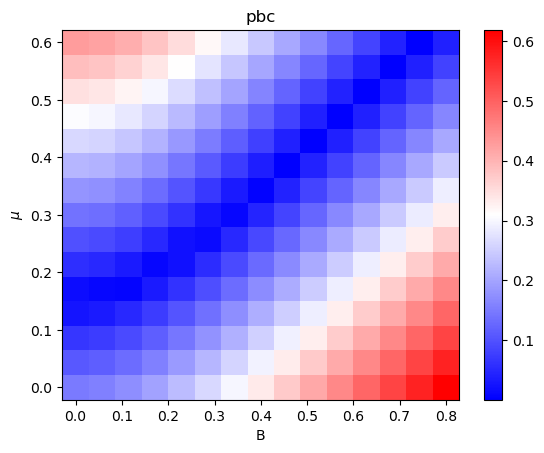

In [1]:
# %matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
import kwant
from numpy import sqrt,kron
from scipy.sparse.linalg import eigsh

#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z


'''固定参数'''
hbar = 1.055e-34    #J.S  
me = 9.109e-31    #kg
meff = 0.03*me
delta0 = 0.12   #meV


a = 1e-8 #m
L = 300

#g·mu_B的值
gmu = 1.447  #meV/T
meV = 1.60217e-22
t = hbar**2/(2*meff*a**2)/meV   #量纲为meV
gamma = 0.15 #meV
alpha = 0.8  #约化Rashba，等于alpha/a,单位为meV


#self energy
def self_eng(omega):
    return -gamma * (omega*kron(tau_0,sigma_0) + delta0*kron(tau_x,sigma_0)) / sqrt(delta0**2 - omega**2)

def sys_bands(B,mu,omega=0,PBC=True):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1,0)))
    else: 
        sys = kwant.Builder()
    lat = kwant.lattice.square(a=1, norbs=4, name='wire')
    es = 1e-3
    def system_shape(pos):
        return -L//2 - es < pos[0] < L//2 + es and 0 - es < pos[1] < 1
    
    def onsite_SC(site):
        return (2 * t - mu)*kron(tau_z,sigma_0) + self_eng(omega) + 1/2*gmu*B*kron(tau_0,sigma_x) 
    
    def hoppingx(site1,site2):
        x,y = site1.pos
        return  -t*kron(tau_z,sigma_0) + 1j*alpha/2*kron(tau_z,sigma_y) 

    sys[lat.shape(system_shape, (0, 0))] = onsite_SC
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    return sys



def compute_phase_pbc(B_range, mu_range):
    E = np.zeros((len(B_range),len(mu_range)))
    for i,B in enumerate(B_range):
        for j,mu in enumerate(mu_range):
            sys = sys_bands(B=B,mu=mu,PBC=True).finalized()
            band_sys = kwant.physics.Bands(sys)
            E[i,j] = np.min(np.abs(band_sys(0)))

    return E

# def compute_phase_obc(B_range, mu_range):
#     E = np.zeros((len(B_range),len(mu_range)))
#     for i,B in enumerate(B_range):
#         for j,mu in enumerate(mu_range):
#             sys = sys_bands(PBC=False,B=B,mu=mu).finalized()
#             ham = sys.hamiltonian_submatrix()
#             eng = eigsh(ham, k=10, sigma=1e-10, return_eigenvectors=False)
#             # eng_sorted = np.sort(eng)
#             E[i,j] = np.min(np.abs(eng))
#     return E


# Compute data
B_range = np.linspace(0, 0.8, 15)
mu_range = np.linspace(0, 0.6, 15)
E_pbc = compute_phase_pbc(B_range, mu_range)
# E_obc = compute_phase_obc(B_range, mu_range)



X, Y = np.meshgrid(B_range, mu_range)
plt.figure()
plt.pcolormesh(X, Y, E_pbc, cmap='bwr', shading='auto') 
plt.title('pbc')
plt.xlabel('B')
plt.ylabel('$\\mu$')
cbar = plt.colorbar()  
# cbar.set_label('2e^2/h', fontsize=12) 
plt.show()

In [3]:
B = 0.3
mu = 0


sys = sys_bands(PBC=True,B=B,mu=mu).finalized()
band_sys = kwant.physics.Bands(sys)
print(np.min(np.abs(band_sys(0))))



sys = sys_bands(PBC=False,B=B,mu=mu).finalized()
ham = sys.hamiltonian_submatrix()
eng = eigsh(ham, k=10, sigma=1e-10, return_eigenvectors=False)

print(np.min(np.abs(eng)))


0.06704999999999998
2.464416144896774e-06


# 固定B，mu的obc，pbc相图

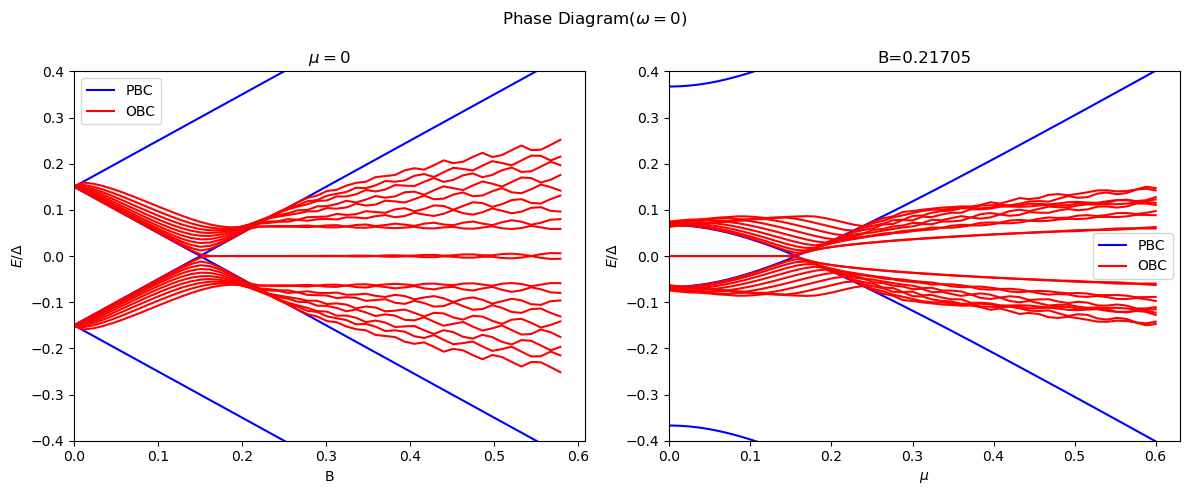

In [3]:
def compute_band_structure_pbc(param_range, B, mu, xlabel):
    E = []
    for param in param_range:
        sys = sys_bands(PBC=True,B=B if xlabel != 'B' else param, mu=mu if xlabel != '$\\mu$' else param).finalized()
        band_sys = kwant.physics.Bands(sys)
        E.append(band_sys(0))
    return E

def compute_band_structure_obc(param_range, B, mu, xlabel):
    E = []
    for param in param_range:
        sys = sys_bands(PBC=False,B=B if xlabel != 'B' else param, mu=mu if xlabel != '$\\mu$' else param).finalized()
        ham = sys.hamiltonian_submatrix()
        eng = eigsh(ham, k=20, sigma=1e-10, return_eigenvectors=False)
        eng_sorted = np.sort(eng)
        E.append(eng_sorted)
    return E



# Compute data
B_range = np.linspace(0, 0.8, 51)
mu_range = np.linspace(0, 0.6, 51)

B_FIX = 0.3
mu_FIX = 0

E_B_pbc = compute_band_structure_pbc(B_range, B=0, mu=mu_FIX, xlabel='B')
E_B_obc = compute_band_structure_obc(B_range, B=0, mu=mu_FIX, xlabel='B')
E_mu_pbc = compute_band_structure_pbc(mu_range, B=B_FIX, mu=0, xlabel='$\\mu$')
E_mu_obc = compute_band_structure_obc(mu_range, B=B_FIX, mu=0, xlabel='$\\mu$')


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Phase Diagram($\\omega=0$)')

# Energy vs Magnetic Field
axes[0].plot(B_range/2*gmu, E_B_pbc, 'b')
axes[0].plot(B_range/2*gmu, E_B_obc, 'r')
axes[0].set_xlabel('B')
axes[0].set_ylabel('$E/\\Delta$')
axes[0].set_ylim(-0.4,0.4)
axes[0].set_xlim(0,)
axes[0].set_title(f'$\\mu={mu_FIX}$')

axes[0].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[0].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[0].legend()

# Energy vs Chemical Potential
axes[1].plot(mu_range, E_mu_pbc, 'b')
axes[1].plot(mu_range, E_mu_obc, 'r')
axes[1].set_xlabel('$\\mu$')
axes[1].set_ylabel('$E/\\Delta$')
axes[1].set_ylim(-0.4,0.4)
axes[1].set_xlim(0,)
axes[1].set_title(f'B={gmu/2*B_FIX}')

axes[1].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[1].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[1].legend()

plt.tight_layout()
plt.show()

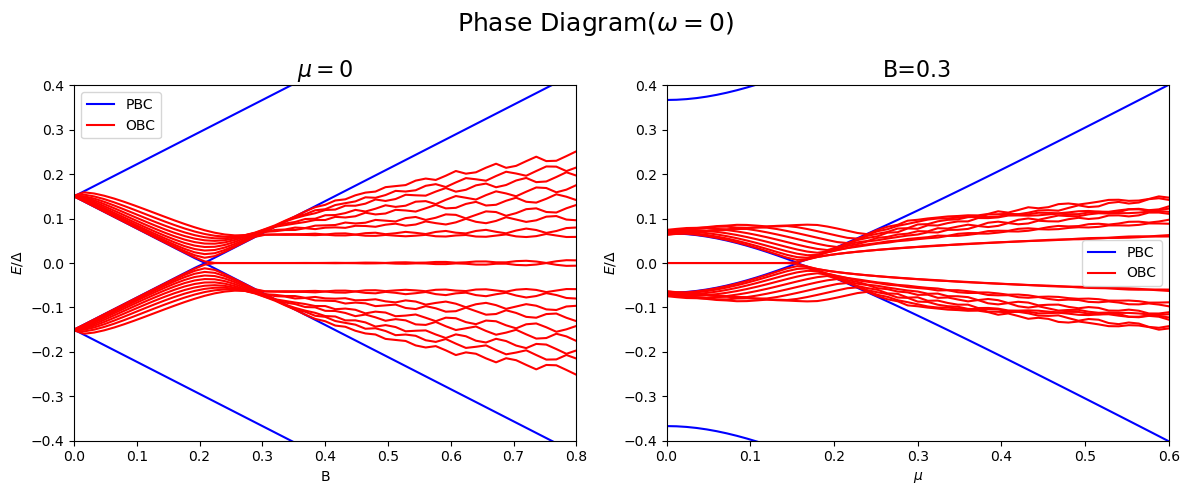

In [15]:
# Plot results
title_dict = {'fontsize': 18}
subtitle_dict = {'fontsize': 16}
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Phase Diagram($\\omega=0$)',**title_dict)

# Energy vs Magnetic Field
axes[0].plot(B_range, E_B_pbc, 'b')
axes[0].plot(B_range, E_B_obc, 'r')
axes[0].set_xlabel('B')
axes[0].set_ylabel('$E/\\Delta$')
axes[0].set_ylim(-0.4,0.4)
axes[0].set_xlim(0,0.8)
axes[0].set_title(f'$\\mu={mu_FIX}$',**subtitle_dict)

axes[0].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[0].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[0].legend()

# Energy vs Chemical Potential
axes[1].plot(mu_range, E_mu_pbc, 'b')
axes[1].plot(mu_range, E_mu_obc, 'r')
axes[1].set_xlabel('$\\mu$')
axes[1].set_ylabel('$E/\\Delta$')
axes[1].set_ylim(-0.4,0.4)
axes[1].set_xlim(0,0.6)
axes[1].set_title(f'B={B_FIX}',**subtitle_dict)

axes[1].plot(B_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[1].plot(B_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[1].legend()

plt.tight_layout()
plt.savefig('Phase.svg', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

